## CNN Adam Computer Vision Model
### Goal 
--- 
Predict what the driver is doing in each picture by using a CNN Model
### Method
---
Using a pool of driver images, each taken in a car with a driver doing something
in the car and categorize each image according to one of the following action: 
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

## Data
In order to train the model, the images have been saved in a Google Drive folder following this structure:
- imgs
  - train
    - c0
    - c1
    - c2
    - c3
    - ...
  - test


In [1]:
# Load the data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
images_path_train="/content/gdrive/My Drive/Colab Notebooks/Computer Vision/Individual Project/imgs/train"
images_path_test_small="/content/gdrive/My Drive/Colab Notebooks/Computer Vision/Individual Project/imgs/6imgtest"
images_path_test="/content/gdrive/My Drive/Colab Notebooks/Computer Vision/Individual Project/imgs/test/allimg"

# CNN - Convolusional Neural Network
In this first scenario I will explore a self build neural network and see what predictions is it possible to get. The model will be done using Keras

In [4]:
import os

# All images are 128x128 pixels
img_size = (128,128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(images_path_train))
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


As expected the training folder we find are the ones previously explicitated.
### Set up the Framework
To set up the framework we will install all the libraries that we will need


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Prepare the data
In this part we will divide the images 70% to train the model and 30% to validate the findings. Moreover the data generator will assing "hot encoded" numeric labels to indicate which class each image belongs to

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    images_path_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    images_path_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Getting Data...
Preparing training dataset...
Found 15702 images belonging to 10 classes.
Preparing validation dataset...
Found 6722 images belonging to 10 classes.


### Define the CNN
The model can now be trained. With Keras we can choose different classifiers, we use the **Adam** classifier. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments

In [ ]:
# ADAM
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense
from keras import optimizers
import tensorflow as tf

#Dense is the fully connected layer
#Flatten is used after all CNN layers and before fully connected layer
#Conv2D is the 2D convolution layer
#MaxPooling2D is the 2D maxx pooling layer

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution layer and another and max poolinglayer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
model.add(Flatten())
model.add(Dense(train_generator.num_classes, activation='softmax'))

# We'll use the ADAM optimizer
#other optimizers can also be used for example SGD stochastic gradient descent
opt = tf.optimizers.Adam(learning_rate=0.001)

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 123, 123, 32)      3488      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 32)        36896     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 10)               

### Train the model 
With the layers of the CNN defined, we're ready to train the model using our image data. 

In [ ]:
# Train the model over 1 epochs
num_epochs = 1
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

523/523 [==============================] - 4288s 8s/step - loss: 0.4493 - accuracy: 0.8553 - val_loss: 0.1067 - val_accuracy: 0.9702


### Evaluate the model
In this part we can evaluate how our model is performing

Generating predictions from validation data...
1/1 [==============================] - 0s 410ms/step


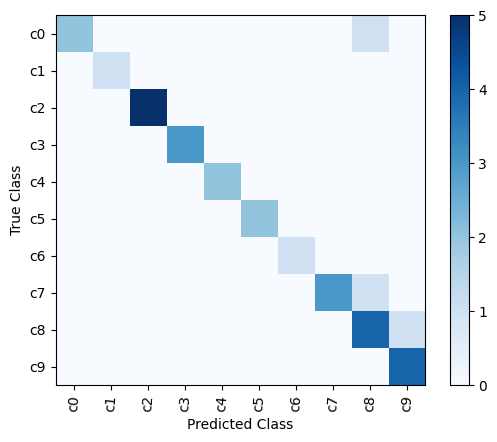

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the moedl to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### Save the model and test it
In this part of the model we will save our mdoele and try to test it with some picture to see how it performs

In [ ]:
from keras.models import load_model

modelFileName = 'shape-classifier.h5'

model.save(modelFileName) # saves the trained model
print("Model saved.")

del model  # deletes the existing model variable

In [ ]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # We need to format the input to match the training data
    # The data generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    img_features = image_array.astype('float32')
    img_features /= 255
    
    # These are the classes our model can predict
    classnames = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
    
    # Predict the class of each input image
    predictions = classifier.predict(img_features)
    
    predicted_classes = []
    for prediction in predictions:
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(class_idx)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

In [ ]:
import os
from random import randint
import numpy as np
from PIL import Image
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

# load the saved model
modelFileName = 'shape-classifier.h5'
model = load_model(modelFileName) 

test_image_files = os.listdir(images_path_test_small)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(images_path_test_small, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
                      
    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])